In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import rbf as RBF
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
#sys.path.insert(0, os.environ['FaultSRC']) #add src folder to path for notebook
# %load_ext snakeviz
import lavavu

%load_ext cython

In [2]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#
#from FME import *
# from tet_mesh import TetMesh
# from dsi_interpolator import DSI
# from fold_event import FoldEvent
# #from ffold_event import FoldEvent
# from structural_frame import StructuralFrame
# from fold_rotation import FoldRotationAngle
# from geological_points import *
# from surfe_wrapper import *
# from dsi_fold_constraint import DSIFoldConstraint
# from fault_segment import FaultSegment

In [3]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -20
boundary_points[0,1] = -20
boundary_points[0,2] = -10
boundary_points[1,0] = 30
boundary_points[1,1] = 20
boundary_points[1,2] = 20
mesh = TetMesh('SectionSupport',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=50000,)
regionmanager = RegionManager(mesh)
boundary_points_small=np.zeros((2,3))
boundary_points_small[0,0] = -16
boundary_points_small[0,1] = -16
boundary_points_small[0,2] = -16
boundary_points_small[1,0] = 25
boundary_points_small[1,1] = 16
boundary_points_small[1,2] = 16
regionmanager.create_region_from_boundary_box(boundary_points_small,'r1')
boundary_points_small[0,0] = -14
boundary_points_small[0,1] = -2.5
boundary_points_small[0,2] = -6
boundary_points_small[1,0] = 14
boundary_points_small[1,1] = 2.5
boundary_points_small[1,2] = 11
regionmanager.create_region_from_boundary_box(boundary_points_small,'r2')

regionmanager.create_properties_for_regions()
# # second mesh is for the model area and the points can be moved around. No interpolation \
# # is performed on this mesh its just here because paraview can contour mesh objects not voxets
# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.6
# mesh2 = TetMesh('Flower3DModel')
# mesh2.setup_mesh(boundary_points2,maxvol=0.5)



# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.8
# mesh3 = TetMesh('Flower3DSupport2')
# mesh3.setup_mesh(boundary_points2,maxvol=0.01)

print(mesh.n_elements)
roof = 15.1
floor = -5.4
stack = 0
solver='spqr'

53378


In [4]:
stratigraphy = DSI(mesh,region='everywhere',shape='square')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
stratigraphy.add_strike_dip_and_value([2.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([-6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([0.1,0.1,1.1],90.,0.,0.)
#fault.add_strike_and_dip([6.,0.1,roof],180,80,itype='gx')
# for y in range(0,15):
# #     fault.add_point([18.,y,18],val=0,itype='gx')
# #     print(y)#y = 0
#     stratigraphy.add_point([10.,y,10],val=0)
#     stratigraphy.add_point([8.,y,0],val=0)

#     stratigraphy.add_point([-10.,y,-10],val=0)
#     stratigraphy.add_point([-12.,y,-10],val=1)
# #     stratigraphy.add_strike_and_dip([-12.,y,0],0,0)
stratigraphy.setup_interpolator(cgw=.1)
stratigraphy.solve_system(solver='chol')
mesh.update_property('strati',stratigraphy.c)
# mesh.plot_mesh('strati')

Setting up interpolator with 4 value control points 
        4 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [5]:
fault = FaultSegment(mesh=mesh,name='FaultSegment1',shape='square')

fault.add_point([2.5,.5,1.5],0.,itype='gz')
fault.add_point([2.5,-.5,1.5],1.,itype='gz')


fault.add_point([10,0,-5],1.,itype='gy')

for y in range(-15,15):
    fault.add_point([18.,y,18],0,itype='gy')
    fault.add_point([10,y,-5],1.,itype='gy')

    fault.add_strike_dip_and_value([18.,y,18],strike=180,dip=85,val=0,itype='gx')

flag = mesh.nodes[:,2] < -5# dist>6000
flag = np.logical_and(flag,mesh.nodes[:,0]<10)
mesh.properties['flag'] = flag.astype(float)
flag = flag[mesh.elements]
flag = np.all(flag,axis=1)
ogw = 500
ogw = ogw / mesh.n_elements#np.sum(flag)#
fault.interpolators['gx'].add_elements_gradient_orthogonal_constraint(np.arange(0,mesh.n_elements)[flag],np.array([0.,1.,0.])[None,:],w=ogw)
fault.interpolators['gx'].add_elements_gradient_orthogonal_constraint(np.arange(0,mesh.n_elements)[flag],np.array([1.,0.,0.])[None,:],w=ogw)
ogw = 300 
ogw /= mesh.n_elements
cgw = 500
cgw = cgw / mesh.n_elements
fault.buildFaultFrame(
    solver='chol',   
    guess=None,
   gxxgy=2*ogw,
   gxxgz=2*ogw,
   gyxgz=ogw,
   gxcg=cgw,
   gycg=cgw,
   gzcg=cgw,
   shape='square',
    gx=True,
    gy=True,
    gz=True
)

Setting up interpolator with 30 value control points 
        30 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009367
Setting up interpolator with 61 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009367
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009367


In [6]:
hangingwall = mesh.properties[fault.interpolators['gx'].propertyname]>0
mesh.regions['footwall'] =np.logical_and(~hangingwall,mesh.regions['r1'])
mesh.regions['hangingwall'] = np.logical_and(hangingwall,mesh.regions['r1'])
print(mesh.regions)

{'everywhere': array([ True,  True,  True, ...,  True,  True,  True]), 'r1': array([False, False, False, ...,  True, False,  True]), 'r2': array([False, False, False, ..., False, False, False]), 'footwall': array([False, False, False, ..., False, False, False]), 'hangingwall': array([False, False, False, ...,  True, False,  True])}


In [7]:
fault.buildFaultDisplacementField(dm=2)#dm=1#,overprint='yes')


In [8]:
newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')

newpoints  = fault.applyFault(newpoints,region='r1',steps=20)

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=200)
mesh.update_property('strati_int',interp)

#logic = mesh.properties[fault.interpolators['gx'].propertyname][mesh.regions['r1']]>0
#np.savetxt('fault1movedpoints.txt',newpoints[logic],delimiter=',')
# newpoints = fault2.applyFault(newpoints,region='r1')
# logic = mesh.properties[fault2.interpolators['gx'].propertyname][mesh.regions['r1']]>0
# np.savetxt('fault2movedpoints.txt',newpoints[logic],delimiter=',')

#lv.display()

In [9]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        'strati',#fault.interpolators['gx'].propertyname,
#         colour=colours[s],
        isovalue=0,
        name='stratigraphy',#fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
#         region="FaultSegmentRegion%i"%s
     )
strati = mesh.properties['strati_int']
strati=strati[~np.isnan(strati)]
for s in np.linspace(np.min(strati),np.max(strati),10):#i in range(-10,10,2):

    mesh.lv_plot_isosurface(
            'strati_int',
            lv,#fault.interpolators['gx'].propertyname,
    #         colour=colours[s],
            isovalue=s,
            name='stratigraphy_faultedhw%f'%s,#fault.interpolators['gx'].propertyname,
            interactive=False,
            draw=False,
            region="r1"
        )
#     mesh.lv_plot_isosurface(
#             'strati_int',
#             lv,#fault.interpolators['gx'].propertyname,
#     #         colour=colours[s],
#             isovalue=s,
#             name='stratigraphy_faultedfw%f'%s,#fault.interpolators['gx'].propertyname,
#             interactive=False,
#             draw=False,
# #             region="footwall"
#         )
# surf = lv.triangles("strati_int",colour='green')
# surf.vertices(stratinodes)
# surf.indices(stratitris)

# surf = lv.triangles("fault",colour='blue')
# surf.vertices(faultnodes)
# surf.indices(faulttris)

# points = lv.points("points",pointsize=4,pointtype="sphere",colour='red')
# points.vertices(mesh.nodes[mesh.elements[logic]])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()
#lv.display()

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


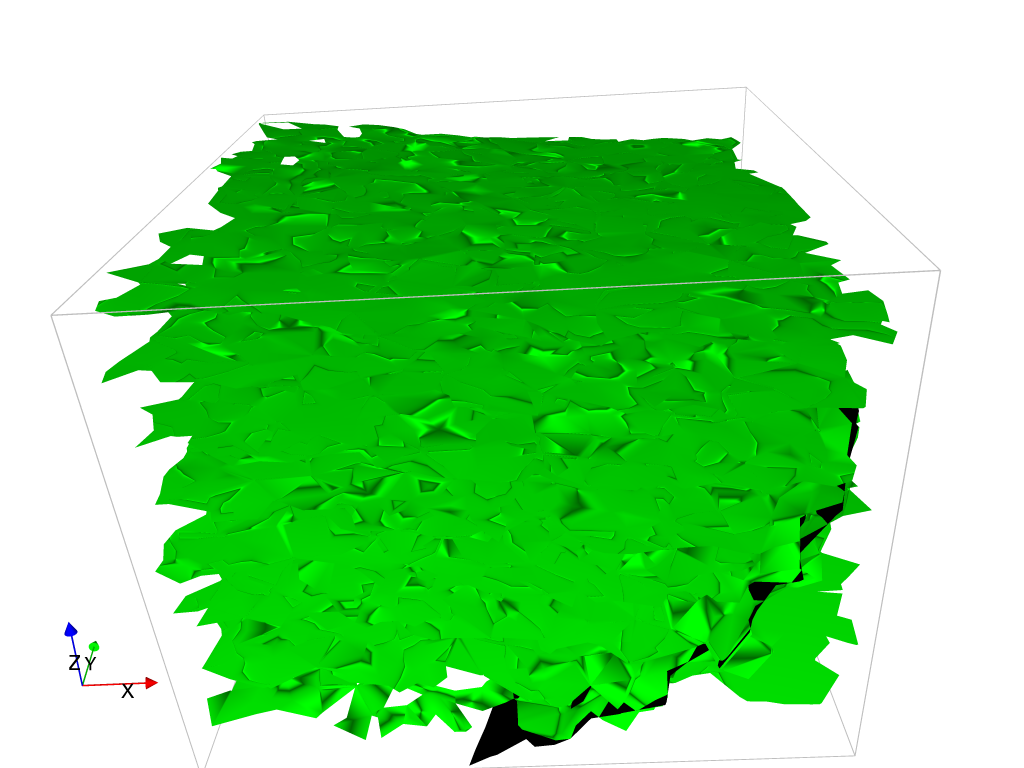

In [23]:
# lv.rotate('x',-90)
lv.rotation(-61.236297607421875,-1.9830615520477295,2.694277763366699)

lv.display()

In [10]:
lv.image("./data/meshnodesorig_fault.jpg")

''

In [ ]:
lowx = -4
highx = 4
logic = mesh.nodes[:,0]<lowx#np.logical_or(mesh.nodes[:,0]>highx,mesh.nodes[:,0]<lowx)
mesh.regions['overlap'] = logic
# mesh.indices = np.array(range(0,mesh.n_nodes))
# sharedindices = mesh.indices[logic]
# node_values = mesh.properties['gx1'][mesh.indices[logic]]
# As = np.zeros(node_values.shape)
# As[:] = 1

fault2 = FaultSegment(mesh=mesh,name='FaultSegment2',shape='square')

fault2.add_strike_dip_and_value([10.22,1.31,roof],strike=180,dip=70,val=0,itype='gx')

# fault2.add_point([2.5,.5,1.5],0.,itype='gz')
# fault2.add_point([2.5,-.5,1.5],1.,itype='gz')
fault2.overlapFaultSegments(fault,mesh.regions['overlap'])
fault2.buildFaultFrame(solver='chol',shape='square')


fault2.buildFaultDisplacementField(dm=5)#dm=1#,overprint='yes')


                            

Setting up interpolator with 1 value control points 
        1 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [ ]:
# newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
newpoints  = fault2.applyFault(newpoints,region='r1',steps=20)
logic = mesh.properties[fault2.interpolators['gx'].propertyname][mesh.regions['r1']]>0

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=200)
mesh.update_property('strati_int',interp)

In [ ]:
import lavavu
lv = lavavu.Viewer()
mesh.properties['overlap'] = mesh.regions['overlap'].astype(float)
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
#          region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        'overlap',
#         colour=colours[s],
        isovalue=0,#np.mean(mesh.properties[fault.interpolators['gx'].propertyname]),
        name='overlap',
        interactive=False,
        lv=lv,
        draw=False,
#          region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        fault2.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault2.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
#          region="r1"
#         region="FaultSegmentRegion%i"%s
    )
# mesh.lv_plot_isosurface(
#         'strati',#fault.interpolators['gx'].propertyname,
# #         colour=colours[s],
#         isovalue=0,
#         name='stratigraphy',#fault.interpolators['gx'].propertyname,
#         interactive=False,
#         lv=lv,
#         draw=False,
# #         region="FaultSegmentRegion%i"%s
#     )
# strati = mesh.properties['strati_int']
# strati=strati[~np.isnan(strati)]
for s in np.linspace(np.min(strati),np.max(strati),10):#i in range(-10,10,2):
    mesh.lv_plot_isosurface(
            'strati_int',#fault.interpolators['gx'].propertyname,
    #         colour=colours[s],
            isovalue=s,
            name='stratigraphy_faulted%f'%s,#fault.interpolators['gx'].propertyname,
            interactive=False,
            lv=lv,
            draw=False,
            region="r1"
        )
# surf = lv.triangles("strati_int",colour='green')
# surf.vertices(stratinodes)
# surf.indices(stratitris)

# surf = lv.triangles("fault",colour='blue')
# surf.vertices(faultnodes)
# surf.indices(faulttris)

# points = lv.points("points",pointsize=4,pointtype="sphere",colour='red')
# points.vertices(mesh.nodes[mesh.elements[logic]])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()